In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk import wordpunct_tokenize, word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

In [3]:
df = pd.read_csv("tweets.csv")
df.head()

,Unnamed: 0,user,date,text,favorite_count,label
0,98,TheTrueAggie,Mon Dec 02 19:37:02 +0000 2019,She doesn't care about the use of tithing or e...,62,neg
1,49,JReubenCIark,Tue Dec 03 09:22:54 +0000 2019,LMAO Merry Christmas from the self-parodying p...,52,neg
2,22,Matthew_7_14,Tue Dec 03 17:42:56 +0000 2019,Got the text from #LightTheWorld to go donate ...,45,pos
3,60,JPBellum,Tue Dec 03 05:14:13 +0000 2019,Only 2018 #DezNat kids will remember. https://...,40,pos
4,7,JPBellum,Tue Dec 03 21:42:41 +0000 2019,Is there anything you now own that wasn’t alre...,28,pos


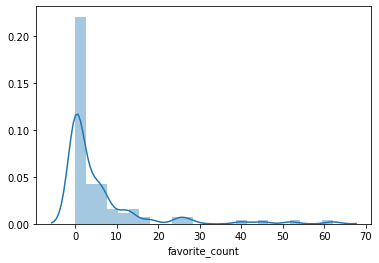

In [4]:
# EDA
sns.distplot(df['favorite_count'])

In [5]:
df['label'].value_counts()

pos    61
neg    39
Name: label, dtype: int64

In [6]:
# train test split
x = df['text']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=801, test_size=.33, stratify=y)

In [7]:
from nltk import wordpunct_tokenize, word_tokenize, sent_tokenize
from nltk.corpus import stopwords

In [8]:
ps = PorterStemmer()
wn = WordNetLemmatizer()

sw = set(stopwords.words('english'))

def text_token(x):
    x = x.lower()
    tokens = wordpunct_tokenize(x)
    tokens = [tok for tok in tokens if tok.isalnum()]
    tokens = [tok for tok in tokens if tok not in sw]
    tokens = [wn.lemmatize(tok) for tok in tokens]
    return(tokens)

In [9]:
# remove stop words
X_train['tokens'] = X_train.apply(text_token)
X_train['clean'] = X_train['tokens'].apply(lambda x: " ".join(x))

X_test['tokens'] = X_test.apply(text_token)
X_test['clean'] = X_test['tokens'].apply(lambda x: " ".join(x))

In [10]:
X_train['clean'].head()

48    reject living prophet reason reject christ dez...
70    rt sisterbellum alpha omega beginning ending s...
66    rt thetrueaggie care use tithing even poor peo...
89    rt jpbellum 2018 deznat kid remember http co s...
30    folk bit protective pew enjoy bit satire dezna...
Name: text, dtype: object

In [11]:
# stemming
stemmed = [ps.stem(word) for word in X_train['clean']]
stemmed

['reject living prophet reason reject christ deznat lighttheworld',
 'rt sisterbellum alpha omega beginning ending saith lord revelation 1 8 churchofjesuschrist lightth',
 'rt thetrueaggie care use tithing even poor people commie hate church deznat http',
 'rt jpbellum 2018 deznat kid remember http co stn30nr5x1',
 'folk bit protective pew enjoy bit satire deznat churchofjesuschrist http co 6uoxv3klsj',
 'repentance joyful process remember god really care care http co chqf89wlel',
 'rt wardpreacher folk bit protective pew enjoy bit satire deznat churchofjesuschrist http co 6uoxv3',
 'place heaven touch earth temple sacred important exquisitely furnishing http co j8qhono6rb',
 'oaksdallinh thank elder oak fearless faithful apostle ambassador savior jesus chri http co xjbizmgrfp',
 'happy birthday hollandjeffreyr churchofjesuschrist deznat twitterstake http co aercfrwjfn',
 'rt thedmt1232 finishing college course today reason thought block deznat list read skil',
 'rt apostolickeys one t

In [12]:
# lemmitization
lemmed = [wn.lemmatize(word) for word in X_train['clean']]
lemmed

['reject living prophet reason reject christ deznat lighttheworld',
 'rt sisterbellum alpha omega beginning ending saith lord revelation 1 8 churchofjesuschrist lightthe',
 'rt thetrueaggie care use tithing even poor people commie hate church deznat http',
 'rt jpbellum 2018 deznat kid remember http co stn30nr5x1',
 'folk bit protective pew enjoy bit satire deznat churchofjesuschrist http co 6uoxv3klsj',
 'repentance joyful process remember god really care care http co chqf89wlel',
 'rt wardpreacher folk bit protective pew enjoy bit satire deznat churchofjesuschrist http co 6uoxv3',
 'place heaven touch earth temple sacred important exquisitely furnishing http co j8qhono6rb',
 'oaksdallinh thank elder oak fearless faithful apostle ambassador savior jesus chri http co xjbizmgrfp',
 'happy birthday hollandjeffreyr churchofjesuschrist deznat twitterstake http co aercfrwjfn',
 'rt thedmt1232 finishing college course today reason thought block deznat list read skilled',
 'rt apostolickeys o

In [13]:
vec = TfidfVectorizer()
X_counts = vec.fit_transform(X_train['clean'])
df_tfidf = pd.DataFrame(X_counts.toarray(), columns=vec.get_feature_names())
df_tfidf.head()

X_test_vec = vec.transform(X_test['clean'])
X_train_vec = vec.transform(X_train['clean'])

y_train = pd.get_dummies(y_train)['pos']
y_test = pd.get_dummies(y_test)['pos']

In [14]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

df['score'] = df['text'].apply(lambda x: sid.polarity_scores(x)['compound'])

# explain compound polarity scores

In [15]:
def make_label(x):
    if x >= 0:
        label = 'pos'
    #elif x == 0:
    #    label = 'neutral'
    else:
        label = 'neg'
    return(label)

In [16]:
df['sent_label'] = df['score'].apply(make_label)

In [17]:
pd.crosstab(df['label'], df['sent_label']).apply(lambda x: x/x.sum(), axis=1)

sent_label,neg,pos
label,,
neg,0.487179,0.512821
pos,0.032787,0.967213


In [19]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

svc = SVC(kernel='linear')
svc.fit(X_train_vec, y_train)
yhatsvm = svc.predict(X_test_vec)
acc_svm = accuracy_score(yhatsvm, y_test)
acc_svm

0.7878787878787878

In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

clf = DecisionTreeClassifier()
clf.fit(X_train_vec, y_train)
yhatdt = clf.predict(X_test_vec)
acc_dt = accuracy_score(yhatdt, y_test)
acc_dt

0.5757575757575758

In [21]:
# Importance
Importance = pd.DataFrame({'Importance': clf.feature_importances_*100}, index= df_tfidf.columns)
Importance = Importance.iloc[clf.feature_importances_ > 0,:]
Importance = Importance.sort_values('Importance', axis=0, ascending=True)
Importance.sort_values('Importance', axis=0, ascending=False)[1:7]

,Importance
deznat,14.511216
life,12.086881
mormon,10.398273
away,9.242909
true,6.082431
ldzion,5.964757


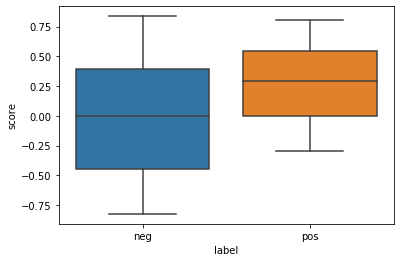

In [22]:
import seaborn as sns
sns.boxplot(x='label',y='score',data=df)

In [23]:
pd.crosstab(df['label'], df['sent_label'])

sent_label,neg,pos
label,,
neg,19,20
pos,2,59


In [24]:
acc_sent = (19 + 59) / (19 + 59 + 2 + 20)
acc_sent

0.78

In [25]:
acc = {'SVM': acc_svm, 
       'Decision trees': acc_dt, 
       'Sentiment analysis': acc_sent}
acc

{'SVM': 0.7878787878787878,
 'Decision trees': 0.5757575757575758,
 'Sentiment analysis': 0.78}